In [4]:
# Importing Libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
#import talib
import random

In [23]:
print(tf.__version__)

1.10.0


In [8]:
# Importing dataset
dataset = pd.read_csv('INFY.NS.csv')
dataset = dataset.dropna()
dataset = dataset[['Open', 'High', 'Low', 'Close']]



In [11]:
#Preparing the dataset
dataset['H-L'] = dataset['High'] - dataset['Low']
dataset['O-C'] = dataset['Close'] - dataset['Open']
dataset['3day MA'] = dataset['Close'].shift(1).rolling(window = 3).mean()
dataset['10day MA'] = dataset['Close'].shift(1).rolling(window = 10).mean()
dataset['30day MA'] = dataset['Close'].shift(1).rolling(window = 30).mean()
dataset['Std_dev']= dataset['Close'].rolling(5).std()
#dataset['RSI'] = talib.RSI(dataset['Close'].values, timeperiod = 9)
#dataset['Williams %R'] = talib.WILLR(dataset['High'].values, dataset['Low'].values, dataset['Close'].values, 7)

dataset['Price_Rise'] = np.where(dataset['Close'].shift(-1) > dataset['Close'], 1, 0)

dataset = dataset.dropna()

data = dataset.iloc[:, 4:]

# Dimensions of data
n = data.shape[0]
p = data.shape[1]
# Make data a np.array
data = data.values


In [12]:
# Splitting the dataset- Training and test data
train_start = 0
train_end = int(np.floor(0.8*n))
test_start = train_end + 1
test_end = n
data_train = data[np.arange(train_start, train_end), :]
data_test = data[np.arange(test_start, test_end), :]

In [13]:
# Scale data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

In [14]:
# Build X and y
X_train = data_train[:, 0:-1]
y_train = data_train[:, -1]
X_test = data_test[:, 0:-1]
y_test = data_test[:, -1]

In [15]:
# Building the Artificial Neural Network:
# Number of features in training data
n_features = X_train.shape[1]

# Neurons
n_neurons_1 = 512
n_neurons_2 = 256
n_neurons_3 = 128

# Session
net = tf.InteractiveSession()

# Placeholder
X = tf.placeholder(dtype=tf.float32, shape=[None, n_features])
Y = tf.placeholder(dtype=tf.float32, shape=[None])

# Initializers
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\anaconda3\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\anaconda3\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\anaconda3\lib

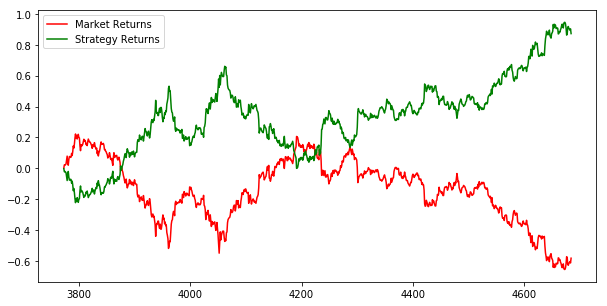

In [16]:
# Hidden weights:
#Layer 1: Variables for hidden weights and biases
W_hidden_1 = tf.Variable(weight_initializer([n_features, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))
#Layer 2: Variables for hidden weights and biases
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))
#Layer 3: Variables for hidden weights and biases
W_hidden_3 = tf.Variable(weight_initializer([n_neurons_2, n_neurons_3]))
bias_hidden_3 = tf.Variable(bias_initializer([n_neurons_3]))

# Output weights:
#Output layer: Variables for output weights and biases
W_out = tf.Variable(weight_initializer([n_neurons_3, 1]))
bias_out = tf.Variable(bias_initializer([1]))

# Hidden layer
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.relu(tf.add(tf.matmul(hidden_2, W_hidden_3), bias_hidden_3))

# Output layer (transpose!)
out = tf.transpose(tf.add(tf.matmul(hidden_3, W_out), bias_out))

# Cost function
mse = tf.reduce_mean(tf.squared_difference(out, Y))

# Optimizer
opt = tf.train.AdamOptimizer().minimize(mse)

# Run initializer
net.run(tf.global_variables_initializer())

# Fitting the neural network
batch_size = 100
epochs = 10
# Run
for e in range(epochs):
    # Shuffle training data
    shuffle_data = np.random.permutation(np.arange(len(y_train)))
    X_train = X_train[shuffle_data]
    y_train = y_train[shuffle_data]
    # Minibatch training
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        batch_x = X_train[start:start + batch_size]
        batch_y = y_train[start:start + batch_size]
        # Run optimizer with batch
        net.run(opt, feed_dict={X: batch_x, Y: batch_y})
        
           

#Predicting the movement of the stock
pred = net.run(out, feed_dict={X: X_test})
y_pred = pred[0]
y_pred = pred[0] > 0.5

dataset['y_pred'] = np.NaN
dataset.iloc[(len(dataset) - len(y_pred)):,-1:] = y_pred
trade_dataset = dataset.dropna()

#Computing Strategy Returns
trade_dataset['Tomorrows Returns'] = 0.
trade_dataset['Tomorrows Returns'] = np.log(trade_dataset['Close']/trade_dataset['Close'].shift(1))
trade_dataset['Tomorrows Returns'] = trade_dataset['Tomorrows Returns'].shift(-1)

trade_dataset['Strategy Returns'] = 0.
trade_dataset['Strategy Returns'] = np.where(trade_dataset['y_pred'] == True, 
             trade_dataset['Tomorrows Returns'], - trade_dataset['Tomorrows Returns'])

trade_dataset['Cumulative Market Returns'] = np.cumsum(trade_dataset['Tomorrows Returns'])
trade_dataset['Cumulative Strategy Returns'] = np.cumsum(trade_dataset['Strategy Returns'])

#Plotting the graph of returns
plt.figure(figsize=(10,5))
plt.plot(trade_dataset['Cumulative Market Returns'], color='r', label='Market Returns')
plt.plot(trade_dataset['Cumulative Strategy Returns'], color='g', label='Strategy Returns')
plt.legend()
plt.show()



In [17]:
print(trade_dataset)

            Open        High         Low       Close        H-L        O-C  \
3773  484.947998  487.520996  476.440002  478.813995  11.080994  -6.134003   
3774  477.873993  482.376007  473.867004  480.001007   8.509003   2.127014   
3775  480.001007  492.714996  480.001007  489.795990  12.713989   9.794983   
3776  493.704987  494.199005  485.046997  488.510010   9.152008  -5.194977   
3777  489.252014  493.407990  485.838989  490.290985   7.569001   1.038971   
3778  489.252014  494.149994  487.026001  493.160004   7.123993   3.907990   
3779  491.972992  511.908997  491.972992  506.368988  19.936005  14.395996   
3780  504.687012  520.418030  501.322998  518.241028  19.095032  13.554016   
3781  508.891998  508.891998  493.951996  496.079010  14.940002 -12.812988   
3782  489.747009  495.089996  484.009003  488.609009  11.080993  -1.138000   
3783  498.651001  509.337006  495.683014  506.566986  13.653992   7.915985   
3784  515.718018  519.379028  510.028992  516.757019   9.350036 